In [3]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#from tqdm import tqdm,tnrange,tqdm_notebook
from tqdm.notebook import tqdm
import time
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
sns.set()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
print(device)

cuda


## Load data from files

In [5]:
#Path to data
pi0_data_path = 'pi0.npz'
eta_data_path = 'eta.npz'
bck_data_path = 'bck.npz'

In [6]:
#Load data from files

######--------------------- pi0 -------------------------######
data_pi0 = np.load(pi0_data_path, allow_pickle=True)
print(list(data_pi0.keys()))

pi0_Cluster = data_pi0["Cluster"]
pi0_Cluster.reshape(-1,1,50,50)

pi0_ClusterType = data_pi0["ClusterType"]
pi0_ClusterE = data_pi0["ClusterE"]
pi0_ClusterPt = data_pi0["ClusterPt"]
pi0_ClusterModuleNumber = data_pi0["ClusterModuleNumber"]
pi0_ClusterX = data_pi0["ClusterX"]
pi0_ClusterY = data_pi0["ClusterY"]
pi0_ClusterM02 = data_pi0["ClusterM02"]
pi0_ClusterM20 = data_pi0["ClusterM20"]
pi0_PartE = data_pi0["PartE"]
pi0_PartPt = data_pi0["PartPt"]
pi0_PartEta = data_pi0["PartEta"]
pi0_PartPhi = data_pi0["PartPhi"]
pi0_PartIsPrimary = data_pi0["PartIsPrimary"]
pi0_PartPID = data_pi0["PartPID"]

['Cluster', 'ClusterType', 'ClusterE', 'ClusterPt', 'ClusterModuleNumber', 'ClusterX', 'ClusterY', 'ClusterM20', 'ClusterM02', 'PartE', 'PartPt', 'PartEta', 'PartPhi', 'PartIsPrimary', 'PartPID']


In [7]:
######--------------------- eta -------------------------######
data_eta = np.load(eta_data_path, allow_pickle=True)
print(list(data_eta.keys()))

eta_Cluster = data_eta["Cluster"]
eta_Cluster.reshape(-1,1,50,50)

eta_ClusterType = data_eta["ClusterType"]
eta_ClusterE = data_eta["ClusterE"]
eta_ClusterPt = data_eta["ClusterPt"]
eta_ClusterModuleNumber = data_eta["ClusterModuleNumber"]
eta_ClusterX = data_eta["ClusterX"]
eta_ClusterY = data_eta["ClusterY"]
eta_ClusterM02 = data_eta["ClusterM02"]
eta_ClusterM20 = data_eta["ClusterM20"]
eta_PartE = data_eta["PartE"]
eta_PartPt = data_eta["PartPt"]
eta_PartEta = data_eta["PartEta"]
eta_PartPhi = data_eta["PartPhi"]
eta_PartIsPrimary = data_eta["PartIsPrimary"]
eta_PartPID = data_eta["PartPID"]

['Cluster', 'ClusterType', 'ClusterE', 'ClusterPt', 'ClusterModuleNumber', 'ClusterX', 'ClusterY', 'ClusterM20', 'ClusterM02', 'PartE', 'PartPt', 'PartEta', 'PartPhi', 'PartIsPrimary', 'PartPID']


In [8]:
######--------------------- bck -------------------------######
data_bck = np.load(bck_data_path, allow_pickle=True)
print(list(data_bck.keys()))

bck_Cluster = data_bck["Cluster"]
bck_Cluster.reshape(-1,1,50,50)

bck_ClusterType = data_bck["ClusterType"]
bck_ClusterE = data_bck["ClusterE"]
bck_ClusterPt = data_bck["ClusterPt"]
bck_ClusterModuleNumber = data_bck["ClusterModuleNumber"]
bck_ClusterX = data_bck["ClusterX"]
bck_ClusterY = data_bck["ClusterY"]
bck_ClusterM02 = data_bck["ClusterM02"]
bck_ClusterM20 = data_bck["ClusterM20"]
bck_PartE = data_bck["PartE"]
bck_PartPt = data_bck["PartPt"]
bck_PartEta = data_bck["PartEta"]
bck_PartPhi = data_bck["PartPhi"]
bck_PartIsPrimary = np.zeros_like(bck_PartE, dtype=bool)
bck_PartPID = data_bck["PartPID"]

['Cluster', 'ClusterType', 'ClusterE', 'ClusterPt', 'ClusterModuleNumber', 'ClusterX', 'ClusterY', 'ClusterM20', 'ClusterM02', 'PartE', 'PartPt', 'PartEta', 'PartPhi', 'PartPID']


## Temporary change for PID into three categories

In [9]:
bck_PartPID[:] = 0 
pi0_PartPID[:] = 1
eta_PartPID[:] = 2

## Test_Train_split
Create a training set and a test set from the initial data

In [10]:
pi0_Cluster_train, pi0_Cluster_test, pi0_ClusterE_train, pi0_ClusterE_test, \
pi0_ClusterType_train, pi0_ClusterType_test,\
pi0_ClusterPt_train, pi0_ClusterPt_test, pi0_ClusterModuleNumber_train, pi0_ClusterModuleNumber_test, \
pi0_ClusterX_train, pi0_ClusterX_test, pi0_ClusterY_train, pi0_ClusterY_test, \
pi0_ClusterM02_train, pi0_ClusterM02_test, pi0_ClusterM20_train, pi0_ClusterM20_test, \
pi0_PartE_train, pi0_PartE_test, pi0_PartPt_train, pi0_PartPt_test, pi0_PartEta_train, \
pi0_PartEta_test, pi0_PartPhi_train, pi0_PartPhi_test, pi0_PartIsPrimary_train, pi0_PartIsPrimary_test, \
pi0_PartPID_train, pi0_PartPID_test = train_test_split(
    pi0_Cluster, pi0_ClusterE, pi0_ClusterType, pi0_ClusterPt, pi0_ClusterModuleNumber, pi0_ClusterX, pi0_ClusterY,
    pi0_ClusterM02, pi0_ClusterM20, pi0_PartE, pi0_PartPt, pi0_PartEta, pi0_PartPhi, pi0_PartIsPrimary, 
    pi0_PartPID, test_size=0.2, random_state=42)

In [11]:
eta_Cluster_train, eta_Cluster_test, eta_ClusterE_train, eta_ClusterE_test, \
eta_ClusterType_train, eta_ClusterType_test,\
eta_ClusterPt_train, eta_ClusterPt_test, eta_ClusterModuleNumber_train, eta_ClusterModuleNumber_test, \
eta_ClusterX_train, eta_ClusterX_test, eta_ClusterY_train, eta_ClusterY_test, \
eta_ClusterM02_train, eta_ClusterM02_test, eta_ClusterM20_train, eta_ClusterM20_test, \
eta_PartE_train, eta_PartE_test, eta_PartPt_train, eta_PartPt_test, eta_PartEta_train, \
eta_PartEta_test, eta_PartPhi_train, eta_PartPhi_test, eta_PartIsPrimary_train, eta_PartIsPrimary_test, \
eta_PartPID_train, eta_PartPID_test = train_test_split(
    eta_Cluster, eta_ClusterE, eta_ClusterType, eta_ClusterPt, eta_ClusterModuleNumber, eta_ClusterX, eta_ClusterY,
    eta_ClusterM02, eta_ClusterM20, eta_PartE, eta_PartPt, eta_PartEta, eta_PartPhi, eta_PartIsPrimary, 
    eta_PartPID, test_size=0.2, random_state=42)

In [12]:
bck_Cluster_train, bck_Cluster_test, bck_ClusterE_train, bck_ClusterE_test, \
bck_ClusterType_train, bck_ClusterType_test,\
bck_ClusterPt_train, bck_ClusterPt_test, bck_ClusterModuleNumber_train, bck_ClusterModuleNumber_test, \
bck_ClusterX_train, bck_ClusterX_test, bck_ClusterY_train, bck_ClusterY_test, \
bck_ClusterM02_train, bck_ClusterM02_test, bck_ClusterM20_train, bck_ClusterM20_test, \
bck_PartE_train, bck_PartE_test, bck_PartPt_train, bck_PartPt_test, bck_PartEta_train, \
bck_PartEta_test, bck_PartPhi_train, bck_PartPhi_test, bck_PartIsPrimary_train, bck_PartIsPrimary_test, \
bck_PartPID_train, bck_PartPID_test = train_test_split(
    bck_Cluster, bck_ClusterE, bck_ClusterType, bck_ClusterPt, bck_ClusterModuleNumber, bck_ClusterX, bck_ClusterY,
    bck_ClusterM02, bck_ClusterM20, bck_PartE, bck_PartPt, bck_PartEta, bck_PartPhi, bck_PartIsPrimary, 
    bck_PartPID, test_size=0.2, random_state=42)

## Merge into train and test sets

In [13]:
Cluster_train = np.concatenate((pi0_Cluster_train, eta_Cluster_train, bck_Cluster_train))
ClusterType_train = np.concatenate((pi0_ClusterType_train, eta_ClusterType_train, bck_ClusterType_train))
ClusterE_train = np.concatenate((pi0_ClusterE_train, eta_ClusterE_train, bck_ClusterE_train))
ClusterPt_train = np.concatenate((pi0_ClusterPt_train, eta_ClusterPt_train, bck_ClusterPt_train))
ClusterModuleNumber_train = np.concatenate((pi0_ClusterModuleNumber_train
                                            , eta_ClusterModuleNumber_train, bck_ClusterModuleNumber_train))
ClusterX_train = np.concatenate((pi0_ClusterX_train, eta_ClusterX_train, bck_ClusterX_train))
ClusterY_train = np.concatenate((pi0_ClusterY_train, eta_ClusterY_train, bck_ClusterY_train))
ClusterM02_train = np.concatenate((pi0_ClusterM02_train, eta_ClusterM02_train, bck_ClusterM02_train))
ClusterM20_train = np.concatenate((pi0_ClusterM20_train ,eta_ClusterM20_train, bck_ClusterM20_train))
PartE_train = np.concatenate((pi0_PartE_train, eta_PartE_train, bck_PartE_train))
PartPt_train = np.concatenate((pi0_PartPt_train, eta_PartPt_train, bck_PartPt_train))
PartEta_train = np.concatenate((pi0_PartEta_train, eta_PartEta_train, bck_PartEta_train))
PartPhi_train = np.concatenate((pi0_PartPhi_train, eta_PartPhi_train, bck_PartPhi_train))
PartIsPrimary_train = np.concatenate((pi0_PartIsPrimary_train, eta_PartIsPrimary_train, bck_PartIsPrimary_train))
PartPID_train = np.concatenate((pi0_PartPID_train, eta_PartPID_train, bck_PartPID_train))

In [14]:
Cluster_test = np.concatenate((pi0_Cluster_test, eta_Cluster_test, bck_Cluster_test))
ClusterType_test = np.concatenate((pi0_ClusterType_test, eta_ClusterType_test, bck_ClusterType_test))
ClusterE_test = np.concatenate((pi0_ClusterE_test, eta_ClusterE_test, bck_ClusterE_test))
ClusterPt_test = np.concatenate((pi0_ClusterPt_test, eta_ClusterPt_test, bck_ClusterPt_test))
ClusterModuleNumber_test = np.concatenate((pi0_ClusterModuleNumber_test
                                            , eta_ClusterModuleNumber_test, bck_ClusterModuleNumber_test))
ClusterX_test = np.concatenate((pi0_ClusterX_test, eta_ClusterX_test, bck_ClusterX_test))
ClusterY_test = np.concatenate((pi0_ClusterY_test, eta_ClusterY_test, bck_ClusterY_test))
ClusterM02_test = np.concatenate((pi0_ClusterM02_test, eta_ClusterM02_test, bck_ClusterM02_test))
ClusterM20_test = np.concatenate((pi0_ClusterM20_test ,eta_ClusterM20_test, bck_ClusterM20_test))
PartE_test = np.concatenate((pi0_PartE_test, eta_PartE_test, bck_PartE_test))
PartPt_test = np.concatenate((pi0_PartPt_test, eta_PartPt_test, bck_PartPt_test))
PartEta_test = np.concatenate((pi0_PartEta_test, eta_PartEta_test, bck_PartEta_test))
PartPhi_test = np.concatenate((pi0_PartPhi_test, eta_PartPhi_test, bck_PartPhi_test))
PartIsPrimary_test = np.concatenate((pi0_PartIsPrimary_test, eta_PartIsPrimary_test, bck_PartIsPrimary_test))
PartPID_test = np.concatenate((pi0_PartPID_test, eta_PartPID_test, bck_PartPID_test))

## Reshape the arrays into [size, 1] for usage with ptorch

In [15]:
Cluster_train = Cluster_train.reshape((ClusterE_train.size,1,50,50))
ClusterType_train = ClusterType_train.reshape((ClusterType_train.size, 1))
ClusterE_train = ClusterE_train.reshape((ClusterE_train.size, 1))
ClusterPt_train = ClusterPt_train.reshape((ClusterPt_train.size, 1))
ClusterModuleNumber_train = ClusterModuleNumber_train.reshape((ClusterModuleNumber_train.size, 1))
ClusterX_train = ClusterX_train.reshape((ClusterX_train.size, 1))
ClusterY_train = ClusterY_train.reshape((ClusterY_train.size, 1))
ClusterM02_train = ClusterM02_train.reshape((ClusterM02_train.size, 1))
ClusterM20_train = ClusterM20_train.reshape((ClusterM20_train.size, 1))
PartE_train = PartE_train.reshape((PartE_train.size, 1))
PartPt_train = PartPt_train.reshape((PartPt_train.size, 1))
PartEta_train = PartEta_train.reshape((PartEta_train.size, 1))
PartPhi_train = PartPhi_train.reshape((PartPhi_train.size, 1))
PartIsPrimary_train = PartIsPrimary_train.reshape((PartIsPrimary_train.size, 1))
PartPID_train = PartPID_train.reshape((PartPID_train.size, 1))

In [16]:
Cluster_test = Cluster_test.reshape((ClusterE_test.size,1,50,50))
ClusterType_test = ClusterType_test.reshape((ClusterType_test.size, 1))
ClusterE_test = ClusterE_test.reshape((ClusterE_test.size, 1))
ClusterPt_test = ClusterPt_test.reshape((ClusterPt_test.size, 1))
ClusterModuleNumber_test = ClusterModuleNumber_test.reshape((ClusterModuleNumber_test.size, 1))
ClusterX_test = ClusterX_test.reshape((ClusterX_test.size, 1))
ClusterY_test = ClusterY_test.reshape((ClusterY_test.size, 1))
ClusterM02_test = ClusterM02_test.reshape((ClusterM02_test.size, 1))
ClusterM20_test = ClusterM20_test.reshape((ClusterM20_test.size, 1))
PartE_test = PartE_test.reshape((PartE_test.size, 1))
PartPt_test = PartPt_test.reshape((PartPt_test.size, 1))
PartEta_test = PartEta_test.reshape((PartEta_test.size, 1))
PartPhi_test = PartPhi_test.reshape((PartPhi_test.size, 1))
PartIsPrimary_test = PartIsPrimary_test.reshape((PartIsPrimary_test.size, 1))
PartPID_test = PartPID_test.reshape((PartPID_test.size, 1))

## Load it to pytorch `tensor`

In [17]:
Cluster_train = torch.tensor(Cluster_train, dtype=torch.float32)
ClusterType_train = torch.tensor(ClusterType_train, dtype=torch.uint8)
ClusterE_train = torch.tensor(ClusterE_train, dtype=torch.float32)
ClusterPt_train = torch.tensor(ClusterPt_train, dtype=torch.float32)
ClusterModuleNumber_train = torch.tensor(ClusterModuleNumber_train, dtype=torch.uint8)
ClusterX_train = torch.tensor(ClusterX_train, dtype=torch.uint8)
ClusterY_train = torch.tensor(ClusterY_train, dtype=torch.uint8)
ClusterM02_train = torch.tensor(ClusterM02_train, dtype=torch.float32)
ClusterM20_train = torch.tensor(ClusterM20_train, dtype=torch.float32)
PartE_train = torch.tensor(PartE_train, dtype=torch.float32)
PartPt_train = torch.tensor(PartPt_train, dtype=torch.float32)
PartEta_train = torch.tensor(PartEta_train, dtype=torch.float32)
PartPhi_train = torch.tensor(PartPhi_train, dtype=torch.float32)
PartIsPrimary_train = torch.tensor(PartIsPrimary_train, dtype=torch.bool)
PartPID_train = torch.tensor(PartPID_train, dtype=torch.short)

In [18]:
Cluster_test = torch.tensor(Cluster_test, dtype=torch.float32)
ClusterType_test = torch.tensor(ClusterType_test, dtype=torch.uint8)
ClusterE_test = torch.tensor(ClusterE_test, dtype=torch.float32)
ClusterPt_test = torch.tensor(ClusterPt_test, dtype=torch.float32)
ClusterModuleNumber_test = torch.tensor(ClusterModuleNumber_test, dtype=torch.uint8)
ClusterX_test = torch.tensor(ClusterX_test, dtype=torch.uint8)
ClusterY_test = torch.tensor(ClusterY_test, dtype=torch.uint8)
ClusterM02_test = torch.tensor(ClusterM02_test, dtype=torch.float32)
ClusterM20_test = torch.tensor(ClusterM20_test, dtype=torch.float32)
PartE_test = torch.tensor(PartE_test, dtype=torch.float32)
PartPt_test = torch.tensor(PartPt_test, dtype=torch.float32)
PartEta_test = torch.tensor(PartEta_test, dtype=torch.float32)
PartPhi_test = torch.tensor(PartPhi_test, dtype=torch.float32)
PartIsPrimary_test = torch.tensor(PartIsPrimary_test, dtype=torch.bool)
PartPID_test = torch.tensor(PartPID_test, dtype=torch.short)

## Load it to pytorch `DataLoader`

In [19]:
dataset_train = utils.TensorDataset( Cluster_train, ClusterType_train, ClusterE_train, ClusterPt_train
                                    , ClusterModuleNumber_train, ClusterX_train, ClusterY_train
                                    , ClusterM02_train, ClusterM20_train, PartE_train, PartPt_train
                                    , PartEta_train, PartPhi_train, PartIsPrimary_train, PartPID_train )

In [20]:
dataset_test = utils.TensorDataset( Cluster_test, ClusterType_test, ClusterE_test, ClusterPt_test
                                    , ClusterModuleNumber_test, ClusterX_test, ClusterY_test
                                    , ClusterM02_test, ClusterM20_test, PartE_test, PartPt_test
                                    , PartEta_test, PartPhi_test, PartIsPrimary_test, PartPID_test )

In [21]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)

In [22]:
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True)

## Instance Noise

In [23]:
# https://arxiv.org/abs/1610.04490
INSTANCE_NOISE = True

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

## Define the network

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(10,10, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(10,5, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.dense_nn = nn.Sequential(
            nn.Linear(3130, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 3),
            nn.ReLU()
        )
        
    def forward(self, cluster, clusNumXYEPt):
        cluster = F.relu(self.conv1(cluster))
        cluster = F.relu(self.conv2(cluster))
        cluster = F.relu(self.conv3(cluster))
        x = self.flatten(cluster)
        x = torch.cat([x, clusNumXYEPt], dim=1)
        logits = self.dense_nn(x)
        return logits

In [36]:
model = CNN().to(device)

In [37]:
print(model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_nn): Sequential(
    (0): Linear(in_features=3130, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
    (5): ReLU()
  )
)


## Set loss function and dataloader

In [27]:
learning_rate = 1e-3

loss_fn = F.cross_entropy

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

## Implement train and test loop
[0:'Cluster', 1:'ClusterType', 2:'ClusterE', 3:'ClusterPt', 4:'ClusterModuleNumber', 5:'ClusterX', 6:'ClusterY', 7:'ClusterM02', 8:'ClusterM20', 9:'PartE', 10:'PartPt', 11:'PartEta', 12:'PartPhi', 13:'PartIsPrimary', 14:'PartPID']

In [42]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        Cl, ClE, ClPt, ClModNum, ClX, ClY, PartPID = data[0].float().to(device), data[2].float().to(device), \
        data[3].float().to(device), data[4].float().to(device), data[5].float().to(device), \
        data[6].float().to(device), data[14].float().to(device)
        
        ClusterProperties = torch.cat([ClE.to(device), ClPt.to(device), ClModNum.to(device), ClX.to(device), ClY.to(device)], dim=1)
        
        #prediction and loss
        pred = model(Cl, ClusterProperties)
        loss = loss_fn(pred, PartPID[:,0].long())
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(ClE)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
        

In [43]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0
    
    with torch.no_grad():
        for data in dataloader:
            Cl, ClE, ClPt, ClModNum, ClX, ClY, PartPID = data[0].float().to(device), data[2].float().to(device), \
            data[3].float().to(device), data[4].float().to(device), data[5].float().to(device), \
            data[6].float().to(device), data[14].float().to(device)
            
            ClusterProperties = torch.cat([ClE.to(device), ClPt.to(device), ClModNum.to(device), ClX.to(device), ClY.to(device)], dim=1)
        
            pred = model(Cl, ClusterProperties)
            test_loss += loss_fn(pred, PartPID[:,0].long()).item()
            correct += (pred.argmax(1) == PartPID[:,0]).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [44]:
def run_training(epochs, start=0):
    dat=[0]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    line1, = ax.plot(dat, label='epoch_loss')
    plt.legend()
    ax.set_xlim([0,epochs])
    fig.canvas.draw()
    for epoch in tqdm(range(start, epochs)):
        print(f"Epoch {epoch+1}\n-------------------------------")
        
        train_loop(dataloader_train, model, loss_fn, optimizer)
        test_loss, _ = test_loop(dataloader_test, model, loss_fn)
        
        if epoch == 0:
            dat = [test_loss]
        else:    
            dat.append(test_loss)
        line1.set_ydata(dat)
        line1.set_xdata(range(len(dat)))
        ax.set_ylim(0, np.max(dat)+1)
        fig.canvas.draw()
        #time.sleep(0.1)
    print("Done!")

<IPython.core.display.Javascript object>


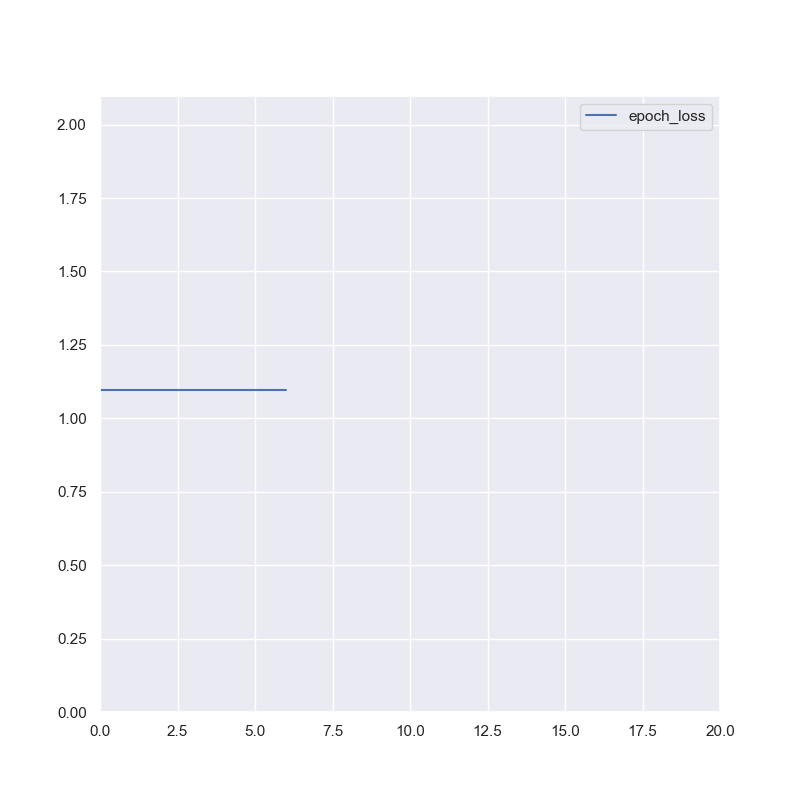

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 1.095209 [    0/102891]
loss: 1.094837 [12800/102891]
loss: 1.097321 [25600/102891]
loss: 1.097714 [38400/102891]
loss: 1.098733 [51200/102891]
loss: 1.095999 [64000/102891]
loss: 1.096411 [76800/102891]
loss: 1.099425 [89600/102891]
loss: 1.098003 [102400/102891]
Test Error: 
 Accuracy: 23.8%, Avg loss: 1.097340 

Epoch 2
-------------------------------
loss: 1.095785 [    0/102891]
loss: 1.096371 [12800/102891]
loss: 1.097731 [25600/102891]
loss: 1.097063 [38400/102891]
loss: 1.098079 [51200/102891]
loss: 1.097429 [64000/102891]
loss: 1.096255 [76800/102891]
loss: 1.096803 [89600/102891]
loss: 1.095937 [102400/102891]
Test Error: 
 Accuracy: 23.8%, Avg loss: 1.097340 

Epoch 3
-------------------------------
loss: 1.099188 [    0/102891]
loss: 1.099115 [12800/102891]
loss: 1.099182 [25600/102891]
loss: 1.098974 [38400/102891]
loss: 1.096702 [51200/102891]
loss: 1.096189 [64000/102891]
loss: 1.099057 [76800/102891]
loss: 1.097375 [89600/10

KeyboardInterrupt: 

In [45]:
plt.ion()
run_training(20)